# Python機械学習 勉強会 第十三回「モデルの評価と改良2」

参考文献：  
Pythonではじめる機械学習　5章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/05-model-evaluation-and-improvement.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

In [2]:
# ワーニングを無視
import warnings
warnings.filterwarnings('ignore')

# pandasの行や列を省略しないようにする
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<br>

---

## はじめに

今回は以下の内容を取り組む

* 評価基準
* まとめと展望

<br>

---

## 5 モデルの評価と改良


<br>

### 5.3 評価基準とスコア

これまでは、クラス分類性能は精度(正確に分類されたサンプルの割合)、回帰性能を$ R^2 $で評価してきた。  
しかしこれらは多数ある様々な評価指標の2例でしかない。

モデルの選択やパラメータチューニングの際には、目的に応じて適切な基準を用いることが重要である。

<br>

#### 5.3.1 最終的な目標を見失わないこと

機械学習を利用する際は、ただ正確に予測することに意味があるのではなく、  
より大きな意思決定の過程の中でその予測を用いる場合が多い。

例えば「交通事故を防ぐ」とか「病院への入院回数を減らす」など、  
**ビジネス評価基準**に対して最も良い影響を与えるモデルやパラメータを選択すべきである。

機械学習アプリケーションに対して特定のアルゴリズムを選択した結果は、**ビジネスインパクト**と呼ばれる。

<br>

#### 5.3.2　2クラス分類における基準

2クラス分類は最も一般的で、概念的には単純な機械学習アプリケーションである。

しかし、このような簡単なクラスであっても、評価にはさまざまな注意点がある。

<br>

##### 5.3.2.1 エラーの種類

単純な精度が評価基準として良くない場合もある。

例えば、自動テストでの癌の早期発見スクリーニングを考えてみる。

テストが陰性であれば患者は健康であると判断し、陽性ならばさらなる検査に回される。  
ここれは、テストが陽性である場合を陽性クラス。陰性の場合を陰性クラスと定義する。

<br>

どのような機械学習アプリケーションであっても、間違いは必ず起こり得る。

今回の場合は、以下のようなパターンが考えられる。

* 真陽性(true positive): 病気の患者を陽性と分類する場合
* 偽陽性(false positive): 健康な患者を陽性と分類してしまう場合
* 真陰性(true negative): 健康な患者を陰性と分類する場合
* 偽陰性(false negative): 病気の患者を陰性と分類してしまう場合

<br>

問題となるのは**偽陽性**と**偽陰性**だが、明らかに避けるべきなのは**偽陰性**である。

これは極端な例ではあるが、偽陽性と偽陰性が同じ重みであることはほぼない。  
ビジネスアプリケーションでは、双方のエラーに値段をつけてみれば、精度の代わりに損失額で評価できる。

<br>

##### 5.3.2.2 偏ったデータセット

エラーのタイプは、2つのクラスの一方がもう片方よりもずっと多い場合(不均衡)に重要となる。

例えばWEBサイトにおける広告のクリックデータなどは、  
ほとんどのデータ(99%)が「クリックされない」データであり、「クリックされた」データ(1%)はずっと少なくなる。

<br>

このようなデータセットを**偏ったデータセット**もしくは**偏ったクラスのデータセット**と呼ぶ。  
実際にはこのような偏ったデータは珍しくない。

<br>

上の例で、ユーザーの広告クリックを99%の精度で予測する分類器を作れたとしよう。  
この場合、素晴らしい出来の分類器ができたと言えるだろうか。

そう思ったのであれば、それはクラスの偏りを考慮していない。

<br>

例えば、常に「クリックされない」と予測する分類器を作ったとしよう。(もはや予測ではないが)  
その場合、99%の精度を達成できるモデルとなる。

しかし、これは意味のある分類器とは言えない。


<br>

このような偏ったデータセットにおいて、精度という基準では潜在的に良いモデルを区別できない。

偏ったデータセットを用いて確認してみる。

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

ここでは、digitsデータセットを用いて、数字の「9」と「それ以外」という、1:9に偏ったデータセットを作った。

常に多数のクラス「それ以外」を予測するダミー分類器を作って、精度がどうなるか見てみる。  
比較のためにDecisionTreeClassifierの結果と比較する。

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Dummy score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Decision Tree score: {:.2f}".format(tree.score(X_test, y_test)))

Unique predicted labels: [False]
Dummy score: 0.90
Decision Tree score: 0.92


何も学習しなくても90%の精度が得られた。  
Decision Treeは学習しても92%と、精度だけで比較するとあまり変わらない。

90%の精度と聞くと素晴らしい性能かと思うかもしれないが、こんなモデルは使い物にならないことは明らかである。

<br>

このような場合は精度以外の評価基準が必要となる。

<br>

##### 5.3.2.3 混同行列

2クラス分類の評価結果を表現する方法で、最も包括的な方法の1つに**混同行列(confusion matrix)**がある。

具体的に、先ほどのデータをLogisticRegressionで分類した結果を用いて、図で説明する。

In [5]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

logreg score: 0.98


In [6]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


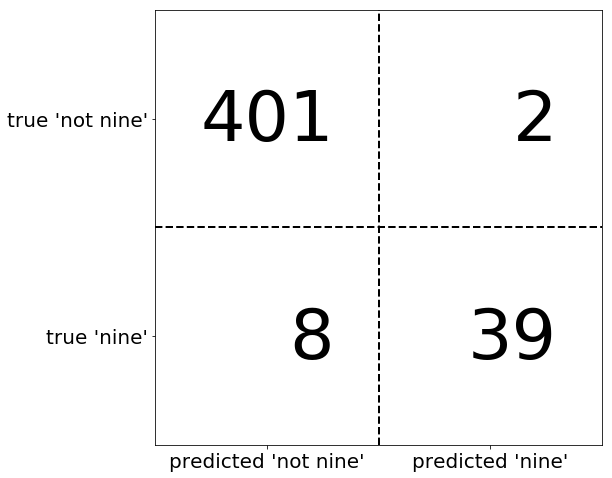

In [7]:
mglearn.plots.plot_confusion_matrix_illustration()

***confusion_matrix***の出力は2×2の配列となる。
* 行は実際のクラスに対応
* 列は予測されたクラスに対応

上の図で説明すると、主対角成分は、正確にクラス分類されたサンプル数を示し、  
それ以外は実際とは違うクラスに分類されたサンプル数を示している。

ここで、「9」を陽性クラスと定義するならば、以下のようになる。

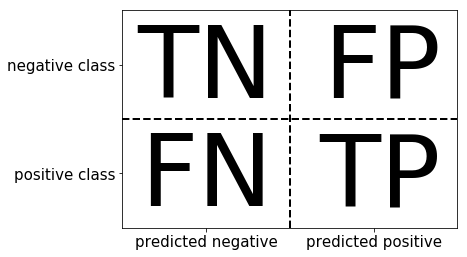

In [8]:
mglearn.plots.plot_binary_confusion_matrix()

* TP:True Positive(真陽性)
* FP:False Positive(偽陽性)
* TN:True Negative(真陰性)
* FN:False Negative(偽陰性)

<br>

この混同行列を用いて、先ほど学習したモデルを比較してみる。

In [9]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))

print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))

print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


対角成分が正確に分類できていることを考えると、明らかに性能に差があることが分かる。

つまり、このような偏ったデータセットに対しては、精度で比較するよりも混同行列で比較する方が適切であることが分かる。

<br>

ただし、毎回混同行列で比較するのは面倒である。  
そこで、混同行列から得られる情報をまとめる手法をいくつか見ていく。

<br>

**精度との関係**

混同行列の結果を1つにまとめる方法の1つは精度である。  
精度は以下のように定義できる。

$$精度 = \frac{TP+TN}{TP+TN+FP+FN}$$

つまり、正確な予測(TP+TN)を、混同行列のすべての要素数の和で割ったもの。

<br>

**適合率、再現率、f-値**

精度の他の手法としてよく使われているものに、**適合率**と**再現率**がある。

<br>

**適合率(precision)**は、陽性であると予測されたものが、どのくらい実際に陽性であったか測定する。

$$適合率 = \frac{TP}{TP+FP}$$

適合率は、偽陽性の数を制限したい場合に性能基準として用いられる。  

例えば、新薬が臨床試験の結果有効であるか予測するモデルを作る際を考えてみる。  
臨床試験は高価なので、薬が実際に効果があることを確信しない限り臨床試験を行いたくない。

簡単に言えば、**過検出**を評価する指標である。

<br>

**再現率(recall)**は、実際の陽性のうち、いくつ陽性と予測できたか測定する。

$$再現率 = \frac{TP}{TP+FN}$$

再現率は、偽陰性を避けたい場合に性能基準として用いられる。

例えば前項で説明した癌の早期発見スクリーニングなどは、まさにあてはまる。  

簡単に言えば、**見逃し**を評価する指標である。

<br>

これら2つの指標はトレードオフの関係にある。  

簡単に言えば、過検出を抑えるならば見逃しは増えるし、見逃しを抑えるなら過検出は増える。

タスクの目的に応じて適切な評価基準を選択する必要がある。

<br>

適合率と再現率は非常に重要な基準だが、これらの片方だけでは全体像はつかめない。

これらをまとめる方法の1つとして、**f-スコア**もしくは**f-値**がある。

具体的には適合率と再現率の調和平均であり、次の式で定義される。

$$F = 2 × \frac{適合率×再現率}{適合率+再現率}$$

これはf-値の一種であり、$f_1$-値とも呼ばれる。

この値は適合率と再現率の双方を取り入れているので、偏った2クラス分類データセットにたいして、精度よりも良い基準となる。

<br>

実際に前項で扱った偏ったデータセットで確認してみる。

In [10]:
from sklearn.metrics import f1_score
print("f1 score most frequent: {:.2f}".format(
    f1_score(y_test, pred_most_frequent)))

print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))

print("f1 score logistic regression: {:.2f}".format(
    f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score tree: 0.55
f1 score logistic regression: 0.89


結果から分かる通り、精度で比較すると差があまりなかったダミーモデルと決定木モデルでは、  
F値で確認すると明らかに差が生じている。

<br>

##### 5.3.2.4 不確実性を考慮に入れる

クラス分類というタスクに対して予測を行うことは、モデルが出力する予測の不確実性を評価する値、  
***decision_function***や***predict_proba***の値に対して、固定した閾値で分けることに相当する。

<br>

次に示す、400点が陰性クラスで50点が陽性クラスとなる、偏ったクラス分類タスクを用いて説明する。


In [11]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

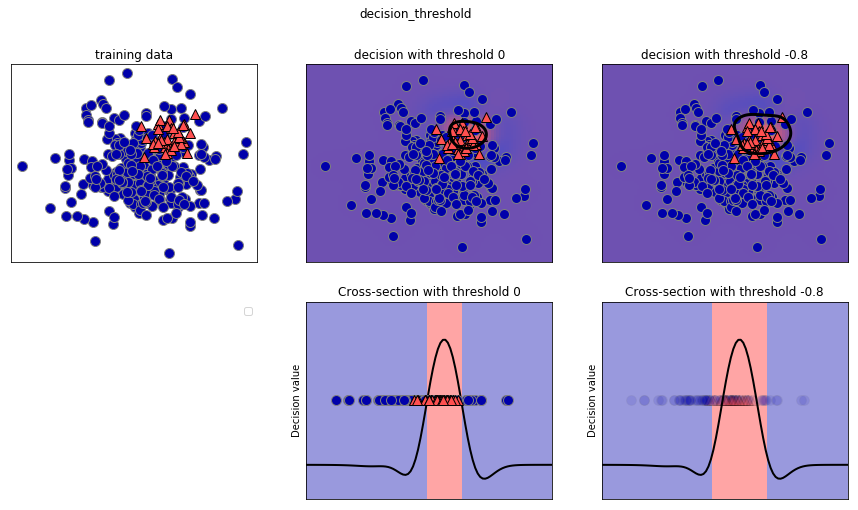

In [12]:
mglearn.plots.plot_decision_threshold()

図の左側に示す訓練データに対して、カーネル法を用いたSVMモデルを訓練した。

図の右側は、決定関数の値をヒートマップとして表現したものである。  
プロットの中央上にある黒い円は、***decision_function***の値がちょうど0になる場所である。

円の内側は陽性(クラス1)となり、外側は陰性(クラス0)と分類される。

<br>

***classification_report***関数を用いて、それぞれのクラスの適合率と再現率を確認する。

In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

   micro avg       0.88      0.88      0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



陽性(クラス1)に関しては、再現率は低く適合率もよくない。  
陰性(クラス0)が多く、クラス0を識別することに集中して学習している。

<br>

例えば、今回のタスクをがんの早期発見の場合だと考えてみる。  
その場合、過検出(適合率が低い)は許容するが、見逃し(再現率が低い)は許容できない。

そういった場合は、決定関数の値をもとに分類する閾値を調整することで、  
再現率が高くなる(=見逃しが低くなる)ように調整できる。

<br>

デフォルトでは、***decision_function***の値が0以上であれば陽性(クラス1)に分類される。  
ここでは、なるべく多くのデータポイントがクラス1に分類されるようにしたいので、閾値を小さくしてみる。

In [14]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [15]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

   micro avg       0.83      0.83      0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



狙い通り、クラス1の再現率が向上した。
* また、適合率は下がった

あらためて図を確認する。

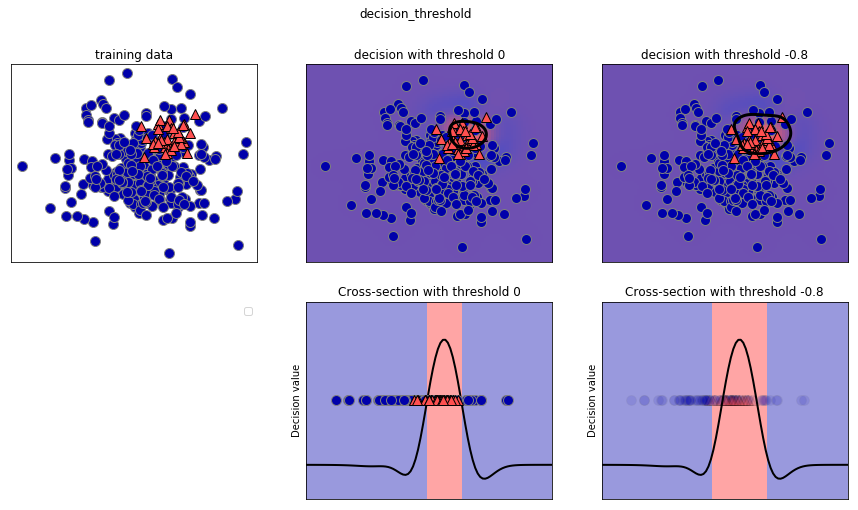

In [16]:
mglearn.plots.plot_decision_threshold()

今回閾値を変更することで、図の一番右側のように、陽性(クラス1)と分類する範囲を広げることができた。

このように、一番簡単に良い結果を得るには決定閾値を変更すればよい。
* ただし、***decision_function***の結果は範囲が一意に決まっていないので、よい閾値を見つける簡単な方法はない

<br>

***predict_proba***メソッドを実装しているモデルであれば、閾値を設定するのは比較的簡単である。

***predict_proba***の出力は0～1の間に固定されており、それぞれ0%～100%に対応している。  
つまり、デフォルトの閾値では0.5(50%)でクラス分類しているが、この閾値を0.3(30%)や0.7(70%)などに変更すれば、  
陽性クラスと分類しやすくなる/しにくくなる、など調整できる。

<br>

##### 5.3.2.5 適合率-再現率カーブ

前項で述べたように、閾値を変更することでクラス分類の適合率と再現率のトレードオフを調整できる。  
しかし、クラス分類器に対してどのような性能を達成すればいいか明らかにならない場合もある。

そのような時に、全ての閾値に対して、適合率と再現率の組み合わせを同時に確認する方法がある。

それは、***適合率-再現率カーブ(precision-recall curve)***という手法である。

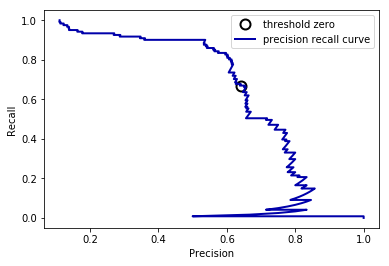

In [17]:
from sklearn.metrics import precision_recall_curve

# カーブがなめらかになるようにデータポイントをふやす
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(
    y_test, svc.decision_function(X_test))

# 0に最も近い閾値を探す
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

上の図はのカーブ上の個々の点は、***decision_function***のさまざまな閾値に対応している。

* 黒丸で表現している点は、***decision_function***のデフォルトである閾値が0の点を示している。  
    つまり、***predict***メソッドを呼び出した時に用いられるトレードオフの点である。

<br>

カーブの右上の角に近ければ近いほど、良いクラス分類器であると言える。
* 適合率(precision)も再現率(recall)も高いということ

<br>

このカーブの結果をさらに解釈すると、再現率を高く保ったまま適合率を0.5前後まで達成することができる事がわかる。  
それ以上に適合率を上げようとすると再現率は大幅に減ってしまう。

このカーブの形はクラス分類器によって異なる。  
同じデータセットに対して、SVMとランダムフォレストで比較してみる。

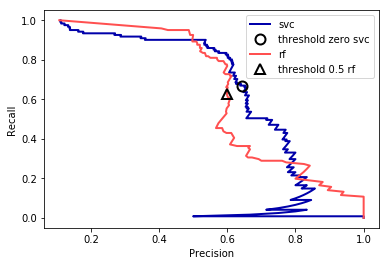

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifierにはpredict_probaはあるがdecision_functionがない
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(
    y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

比較としてみると、今回のデータセットに対しては次にようなことが分かる。

* 非常に高い再現率や適合率が必要な場合にはランダムフォレストの方がよい
* その中間ではSVMの方がよい

<br>

このような微妙な部分に関しては、$f_1値$だけ見て比較しても分からない。

In [19]:
print("f1_score of random forest: {:.3f}".format(
    f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


このように、$f_1値$では、デフォルトで与えられる1点を表しているに過ぎない。  

微妙な領域の目標が与えられているならば、適合率-再現率カーブで確認する方がよい。

<br>

ただし、モデルを構築する度に毎回描画して確認するのは大変である。  
そこで、自動的にモデルを評価するために、カーブの下の領域を積分する**平均適合率(average precision)***という手法が考案されている。

***average_precision_score***関数を用いればいい。
* 複数の閾値を考えるため、***predict***の結果ではなく、***decision_function***もしくは***predict_proba***の結果を渡す

In [20]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


全ての閾値に対して平均を取ると、ランダムフォレストの方がわずかに良い結果になる。  
$f_1値$で確認した結果とは異なることが分かる。

<br>

##### 5.3.2.6 受信者動作特性(ROC)とAUC

さまざまな閾値におけるクラス分類器の挙動を解析するもう1つの手法として、  
**受信者動作特性カーブ(Receiver Operating Characteristics curve)**略して**ROCカーブ**が存在する。

ROCカーブは、**偽陽性率(False Positive Rate: FPR)**を**真陽性率(True Positive Rate: TPR)**に対してプロットする。

* 真陽性率は再現率の別名
* 偽陽性率は、すべての陰性サンプル数に対する偽陽性数の割合

$$真陽性率(TPR) = 再現率 = \frac{TP}{TP+FN}$$

$$偽陽性率(FPR) = \frac{FP}{FP+TN}$$

ROCカーブは、***roc_curve***で計算できる。

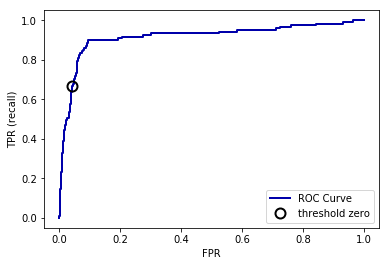

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# 0に最も近い閾値を見つける
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

ROCカーブにおいては理想的な点は左上に近い点である。  
つまり、偽陽性率(FPR)が低く、真陽性率(TPR)=再現率が高い状態である。

* ちなみに、完全ランダムな予測をするクラス分類器に対するROCカーブは、左下から右上への直線となる

図上の黒丸はデフォルトの閾値0であるが、わずかにFPRを増やせばTPRが非常に向上することが分かる。

<br>

SVMとランダムフォレストをROCカーブで比較してみる。

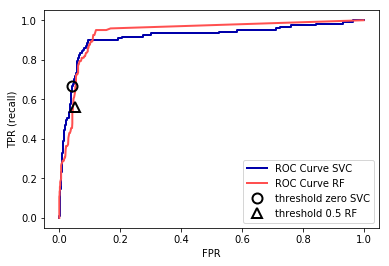

In [22]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10,
         label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

ROCカーブにおいても、カーブ下の領域面積を用いて1つの値にまとめることができる。

* 一般的にカーブ下の領域(Area Under the Curve)をAUCと略して呼ぶ。
* この場合はROC-AUC

<br>

***roc_auc_score***を用いて計算できる。

In [23]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


ROC-AUCで比較すると、ランダムフォレストの方がSVMより少しだけ良い結果となった。

ROCは0～1までのカーブの下の領域なので、AUCは常に0(最悪値)～1(最良値)の間となる。

<br>

ここで、偏ったデータセット(digitsの「9」「9以外」データセット)に対して、  
SVMのパラメータ***gamma***を振った結果を見てみる。

gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.09  accuracy = 0.90  AUC = 0.97
gamma = 0.01  accuracy = 0.90  AUC = 1.00


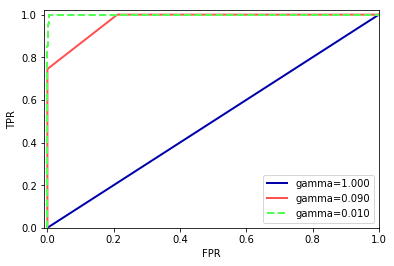

In [24]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.09, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(
          gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")


3つのパラメータに対する精度は、同じ90%である。

しかし、AUCを確認すると3つのモデルの違いがはっきり分かる。  
これが分かれば、モデルの閾値を調整して適切な予測をすることができる。

<br>

一般的に、偏ったデータを評価する際にはAUCがよく用いられている。

<br>

#### 5.3.3 多クラス分類の基準

2クラス分類の評価を取り扱ってきたが、ここで多クラス分類の話をする。

2クラス分類同様に、偏ったデータセットに対して精度は適切な評価基準とは言えない。

<br>

精度以外の一般的なツールとして混同行列があることは既に学んだ。  
ここではdigitsデータセットに対して、それぞれを個別に識別する10クラス分類タスクで確認してみる。

In [25]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, random_state=0)

lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)

print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


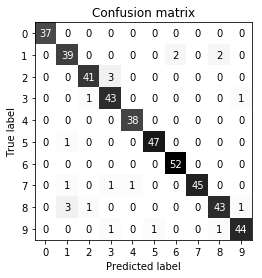

In [26]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")

plt.title("Confusion matrix")
plt.gca().invert_yaxis()

精度は95.3%となった。今回のタスクではデータが偏っていないので、精度で評価しても問題なさそうである。

また、混同行列を確認することで、実際に間違いが少ないことも確認できる。

<br>

***classification_repot***関数を用いて、適合率、再現率、f値を、それぞれのクラスごとに計算できる。

In [27]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

   micro avg       0.95      0.95      0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



このように、各クラスごとに適合率や再現率を確認できる。

しかしクラスの数ごとにこれらを詳細に確認するのは、非常にコストがかかる。

<br>

そこで、偏ったデータセットに対する多クラス分類で最もよく用いられているのは、多クラス版のf値である。  
* ***classification_report***で出力される、最後の3つの行

* micro平均：すべてのクラスの偽陽性、偽陰性、真陽性の総数を計算し、その値を用いて適合率、再現率、f値を計算する  
    つまり、全クラスごちゃまぜで計算するイメージ
    
* macro平均：重みを付けずにクラスごとのf値を平均

* weighted平均：各クラスの数に応じて重みを付けて、クラスごとのf値を平均

一般的には、micro平均やmacro平均が用いられることが多い。

<br>

#### 5.3.4 回帰の基準

一般的に、回帰の場合は今まで扱ってきた$R^2$で問題ない。

<br>

#### 5.3.5 評価基準を用いたモデル選択

これまでさまざまな評価基準を説明してきたが、実際にモデル選択の際にAUCのような基準を用いる方法を確認する。

scikit-learnでは簡単にこれが実現できる。  
***GridSearchCV***や***cross_val_score***などには、***scoring***というパラメータで設定できる。

<br>

例えば、前項であつかった偏ったデータセットで確認してみる。

In [28]:
from sklearn.model_selection import cross_val_score

# デフォルトのクラス分類スコアは精度
print("Default scoring: {}".format(
    cross_val_score(SVC(), digits.data, digits.target == 9, cv=5)))

# scoring="accuracy"にしても変わらない
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9,
                                     scoring="accuracy", cv=5)
print("Explicit accuracy scoring: {}".format(explicit_accuracy))

# scoring="roc_auc"で評価指標を変える
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9,
                           scoring="roc_auc", cv=5)
print("AUC scoring: {}".format(roc_auc))

Default scoring: [0.9 0.9 0.9 0.9 0.9]
Explicit accuracy scoring: [0.9 0.9 0.9 0.9 0.9]
AUC scoring: [0.997 0.997 0.996 0.998 0.992]


In [29]:
from sklearn.model_selection import cross_validate

res = cross_validate(SVC(), digits.data, digits.target == 9,
                     scoring=["accuracy", "roc_auc", "recall_macro"],
                     return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.15,0.09,0.9,1.0,1.00,1.0,0.5,1.0
1,0.14,0.09,0.9,1.0,1.00,1.0,0.5,1.0
2,0.13,0.09,0.9,1.0,1.00,1.0,0.5,1.0
3,0.14,0.09,0.9,1.0,1.00,1.0,0.5,1.0
4,0.14,0.09,0.9,1.0,0.99,1.0,0.5,1.0


<br>

同様に、***GridSearchCV***でも変更できる。

In [30]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target == 9, random_state=0)

# 説明の都合上、よろしくないグリッドを与える
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# デフォルトは精度
grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)

print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973


In [31]:
# ROC-AUCに変える
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)

print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
    roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))


Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


<br>

評価指標に精度を用いると***gamma***=0.0001が選択され、AUCを用いると***gammma***=0.01が選択される。

いずれも交差検証の精度はテストセットで評価した精度と一致しているが、  
AUCで見つけたパラメータの方が、テストセットに対する精度のスコアも高い。

* 偏ったデータセットで評価しているため

<br>

クラス分類における***scoring***パラメータの値として重要なものとして、以下7つが挙げられる。
* accuracy:精度
* roc_auc:ROCカーブのカーブ下領域)
* average_precision:適合率-再現率カーブのカーブ下領域
* f1
* f1_macro
* f1_micro
* f1_weighted

<br>

回帰でよく用いられるのは、以下3つである。
* r2:$R^2$スコア
* mean_squared_error:平均二乗誤差
* mean_absolute_error:平均絶対誤差

<br>

---

### 5.4 まとめと展望

本章では、機械学習アルゴリズムの評価とチューニングについて学んだ。  
重要なポイントについておさらいしておく。

<br>

* テストセットをモデルの訓練やパラメータ選択に用いてはいけない

一般的には、訓練セットとテストセットを分離した後、訓練セットに対して交差検証でパラメータ選択を行うことが多い。  
もちろんネストした交差検証を検討してもいい。

<br>

* モデルの評価基準は、ビジネス目標に沿った形でないといけない

単純に一番良い精度を求めるのか、見逃しをなくしたいのか、過検出を抑えたいのか、  
最終的な目標を考慮して評価基準を選択することが重要。

<br>

これまでで機械学習アルゴリズムおよび、評価基準などについて扱ってきた。  
これらは機械学習を実践する上での日々の基本となる。

次回はいよいよ最終回となるが、データ変換やモデル実行を効率的に行うパイプラインという概念について学び、  
最後に機械学習やデータサイエンス領域の成長につながる内容について取り扱う。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。